# Mercury Challenge Time Series Baserate Models for MERS

This notebook illustrates the Mercury Challenge Baserate model for the Disease Case Count event type.  We present the underlying time series data, and examine autocorrelation and partial autocorrelation functions.  Based on experience with this data the Baserate model uses the seasonal average for the ISO week being predicted multiplied by a scaling factor which is the ratio of recent week counts to their historical averages.  

Finally, we make predictions for the most recent month.

In [1]:
%matplotlib inline

In [2]:
import os
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import (plot_acf, plot_pacf)
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import datetime
from dateutil.parser import parse
import sys
sys.path.append(("../.."))
from Baserate.main.baserate import CaseCountDiseaseBaserate
from Baserate.main.timeseries import (
    evaluate_arima_model, 
    evaluate_models, 
    mean_qs_error, 
    TsDefaults,
    one_step_ahead_forecast,
    hist_avg_predict,
    future_dates
)
from ExpressScore.main.express_score import CaseCountScorer
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight");

/anaconda3/envs/mercury/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
MC_HOME = os.path.abspath("../../..")
DATA_PATH = os.path.join(MC_HOME, "data")
GSR_PATH = os.path.join(DATA_PATH, "gsr")
DISEASE_GSR_PATH = os.path.join(GSR_PATH, "disease_gsr")
RESOURCE_PATH = os.path.join(MC_HOME, "src", "Baserate", "resources")

model_eval_dict = dict()

## Disease Count Series

In [4]:
os.listdir(DISEASE_GSR_PATH)

['Saudi_Arabia_Weekly_MERS_Counts.json']

The Baserate model for Disease Case Count is different than the models used for Civil Unrest, owing to the seasonal nature of MERS.  This model computes a historical average for the week in question and scales it by the ratio of recent weeks to their historical averages.

Data from 2015-05-03 00:00:00 to 2018-07-15 00:00:00


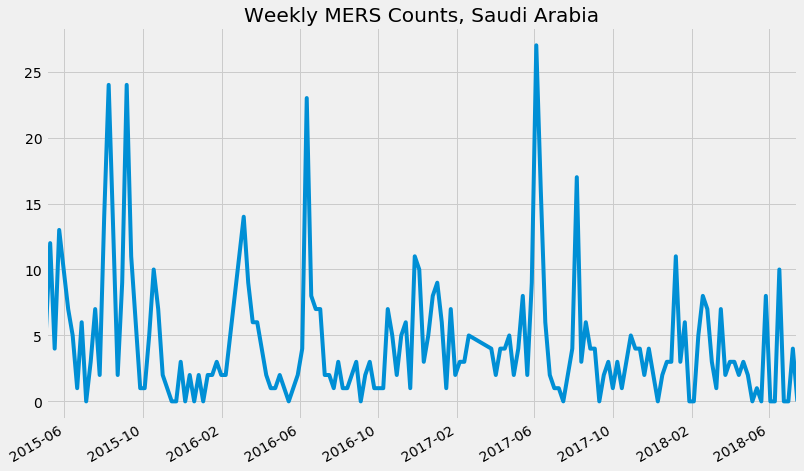

In [5]:
freq = "Weekly"
filename_ = "Saudi_Arabia_Weekly_MERS_Counts.json"
filepath_ = os.path.join(DISEASE_GSR_PATH, filename_)
with open(filepath_, "r", encoding="utf8") as f:
    gsr_ = json.load(f)
#count_dict = {parse(e["Event_Date"]).date(): e["Case_Count"] for e in gsr_}
count_values = [e["Case_Count"] for e in gsr_]
index_ = pd.DatetimeIndex([parse(e["Event_Date"]).date() for e in gsr_])
count_ser = pd.Series(count_values, index=index_)
count_ser = count_ser.sort_index()
count_ser.plot(figsize=(12,8))
print("Data from {0} to {1}".format(count_ser.index[0], count_ser.index[-1]))
plt.title("Weekly MERS Counts, Saudi Arabia");

Testing for Stationary Behavior
ADF Statistic: -8.089
p = 1.39757860173564e-12
Critical Values:
1%: -3.471
5%: -2.880
10%: -2.576
ADF Test rejects null hypothesis of non-stationarity


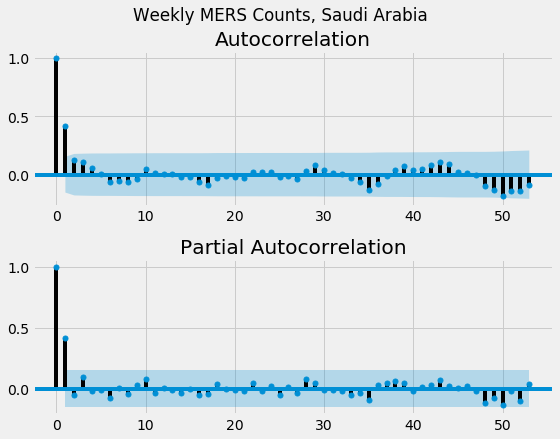

In [6]:
print("Testing for Stationary Behavior")
result = adfuller(count_ser)
print("ADF Statistic: {:.3f}".format(result[0]))
print("p = {}".format(result[1]))
print("Critical Values:")
for key, value in result[4].items():
    print("{0}: {1:.3f}".format(key, value))
if result[0] <= result[4]["5%"]:
    print("ADF Test rejects null hypothesis of non-stationarity")
else:
    print("ADF Test cannot reject null hypothesis of non-stationarity")

fig, axes = plt.subplots(2,1, figsize=(8, 6))
plot_acf(count_ser, ax=axes[0], unbiased=False, lags=53)
plot_pacf(count_ser, ax=axes[1], lags=53)
fig.suptitle("Weekly MERS Counts, Saudi Arabia", y=1.02)
fig.tight_layout()

In [7]:
test_start_date = "2018-07-01"
train = count_ser[:test_start_date]
test = count_ser[test_start_date:]
predictions = hist_avg_predict(train, n_ahead=len(test), season_freq=52)
predictions

{'Model': 'Historical Average Weighted By Recent Trend',
 'Model_Params': 'Period 52',
 'Predictions': 2018-07-08    0.0
 2018-07-15    0.0
 2018-07-22    0.0
 Freq: W-SUN, dtype: float64}

In [8]:
predict_df = pd.DataFrame({"Predicted": predictions["Predictions"],
                           "Actual": test})
predict_df["Quality_Score"] = predict_df.apply(lambda x: CaseCountScorer.quality_score(x.Predicted, 
                                                                                           x.Actual),
                                                   axis=1)
qs_mean = predict_df.Quality_Score.mean()
print("Mean QS = {:.3f}".format(qs_mean))


predict_df

Mean QS = 0.500


,Actual,Predicted,Quality_Score
2018-07-01,0.0,NaN,NaN
2018-07-08,4.0,0.0,0.0
2018-07-15,0.0,0.0,1.0
2018-07-22,NaN,0.0,NaN


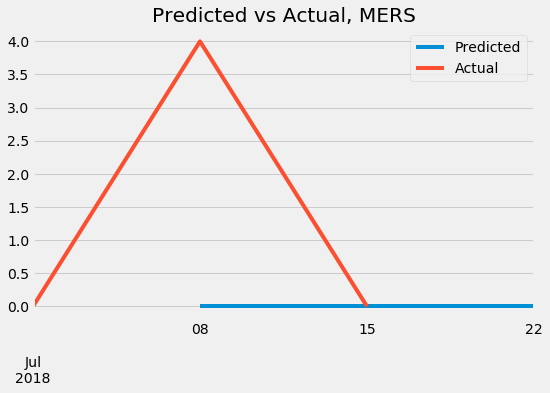

In [9]:
predict_df[["Predicted", "Actual"]].plot(figsize=(8,5))
plt.title("Predicted vs Actual, MERS");

Exporting model parameters to JSON

In [10]:
for k in model_eval_dict:
    model_eval_dict[k]["Model_Params"] = [x for x in model_eval_dict[k]["Model_Params"]]
out_path = os.path.join(RESOURCE_PATH, "MERS TS Model Parameters.json")
with open(out_path, "w") as f:
    json.dump(model_eval_dict, f, indent=2)